## Само решение ДЗ внизу с 12 ячейки.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error

import os


In [14]:
Path_Energy = 'my_PJME_MW.csv'
energy = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])


In [3]:
b_ar = energy['PJME_MW'].values
b_s = pd.DataFrame(data = energy[['PJME_MW']])

C:\Users\Alfa\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
C:\Users\Alfa\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


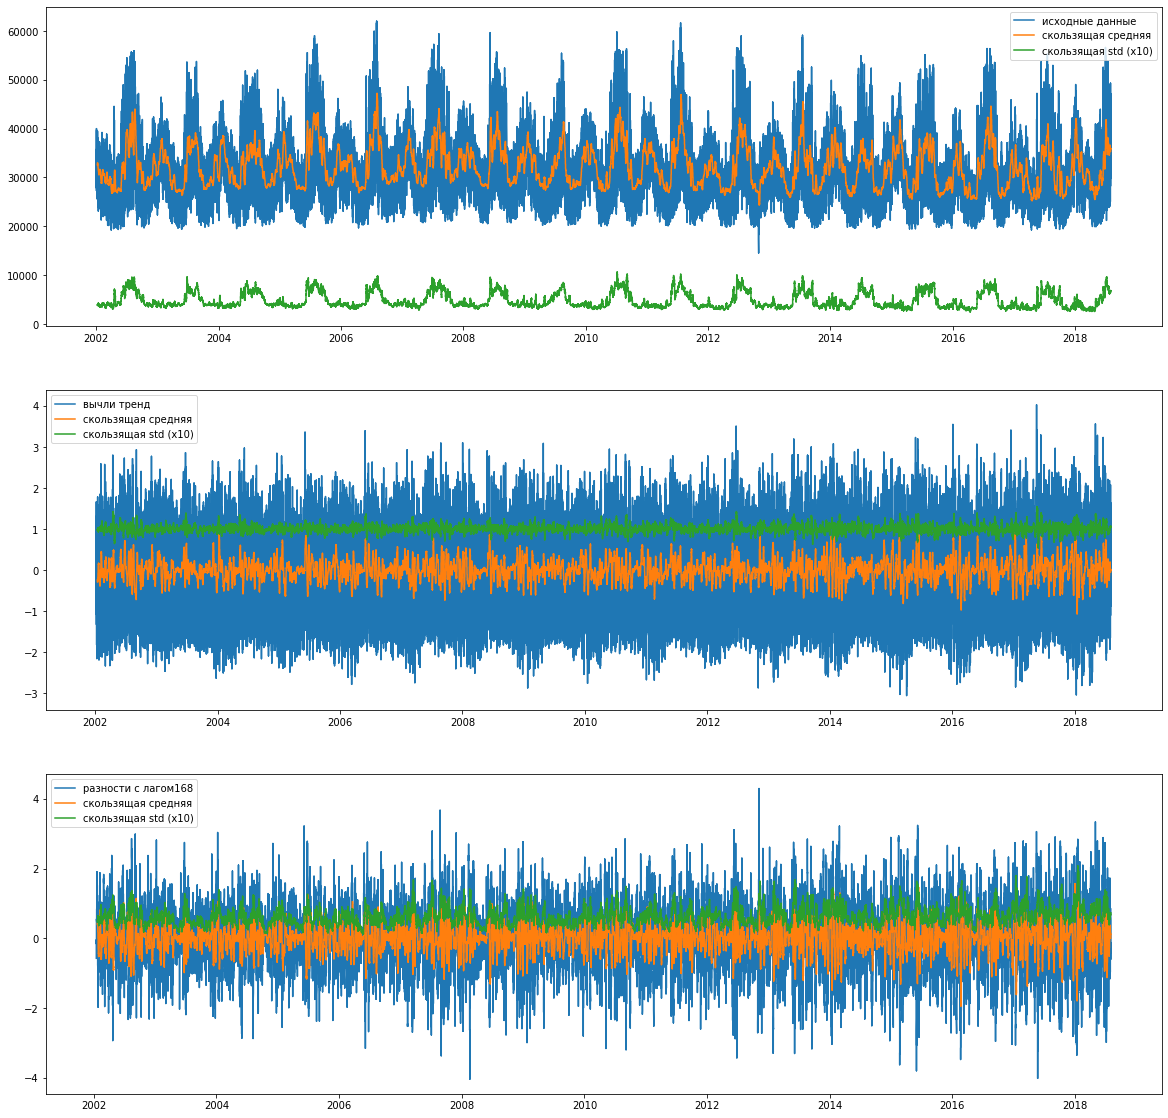

In [4]:
#import matplotlib.dates as mdates
train = b_s.iloc[:-10, :]
test = b_s.iloc[-10:, :]


N2 = 24*7

b_s['z_data'] = (b_s['PJME_MW'] - b_s['PJME_MW'].rolling(window=N2).mean()) / b_s['PJME_MW'].rolling(window=N2).std()
b_s['zp_data'] = b_s['z_data'] - b_s['z_data'].shift(N2)

def plot_rolling(b_s):
    fig, ax = plt.subplots(3,figsize=(20, 20))
    ax[0].plot(b_s.index, b_s['PJME_MW'], label='исходные данные')
    ax[0].plot(b_s['PJME_MW'].rolling(window=N2).mean(), label="скользящая средняя");
    ax[0].plot(b_s['PJME_MW'].rolling(window=N2).std(), label="скользящая std (x10)");
    ax[0].legend()

    ax[1].plot(b_s.index,b_s.z_data, label="вычли тренд")
    ax[1].plot(b_s.z_data.rolling(window=N2).mean(), label="скользящая средняя");
    ax[1].plot(b_s.z_data.rolling(window=N2).std(), label="скользящая std (x10)");
    ax[1].legend()

    ax[2].plot(b_s.index, b_s.zp_data, label="разности с лагом" +str(N2))
    ax[2].plot(b_s.zp_data.rolling(window=N2).mean(), label="скользящая средняя");
    ax[2].plot(b_s.zp_data.rolling(window=N2).std(), label="скользящая std (x10)");
    ax[2].legend()

    #plt.tight_layout()
   #
    plt.show()
plot_rolling(b_s)    

Text(0.5, 1.0, 'Brent 2010-2019')

C:\Users\Alfa\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


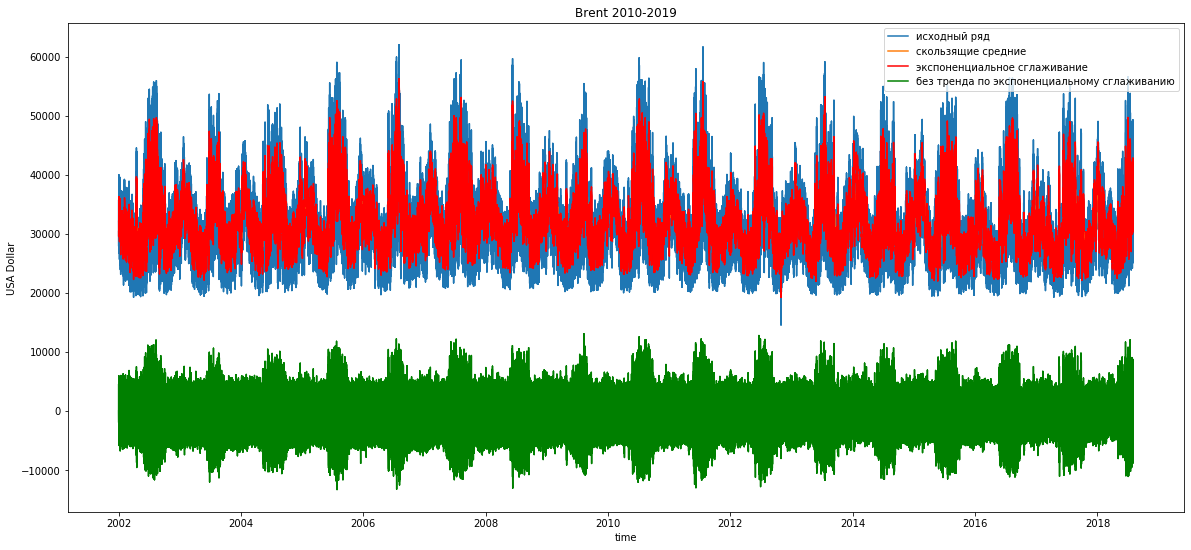

In [5]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

b_ar_exp_1 = exponential_smoothing(energy['PJME_MW'], 0.1)

plt.figure(figsize=(20, 9))
plt.plot(b_s.index, b_s['PJME_MW'], label='исходный ряд')
plt.plot(b_s['PJME_MW'].rolling(window=N2).mean(), label="скользящие средние");

plt.plot(b_s.index,b_ar_exp_1, color = 'red', label="экспоненциальное сглаживание");
plt.plot(b_s.index,b_s['PJME_MW'] - b_ar_exp_1, color = 'green', label="без тренда по экспоненциальному сглаживанию");
plt.xlabel('time')
plt.ylabel('USA Dollar')
plt.legend()
plt.title('Brent 2010-2019')

In [6]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


In [7]:
b_ar_exp_1 = pd.DataFrame(data = b_ar_exp_1, index = b_s.index)
#без тренда 
energy_trend_free = (b_s['PJME_MW'] - b_ar_exp_1.iloc[:,0])
energy_trend_free.head()
DF_brent = sm.tsa.stattools.adfuller(energy_trend_free , regression = 'ctt')
DF_brent

(-52.887964485567935,
 0.0,
 75,
 145298,
 {'1%': -4.371209756407774,
  '5%': -3.8324306460238056,
  '10%': -3.553285187108092},
 2061681.9853488158)

In [8]:
df= pd.DataFrame(b_ar_exp_1)
df.head()
 # добавили историю на глубину 3 измерения от текущего (р=3)
df['t'] = 0.0
df.iloc[1:,1]=df.iloc[:-1,0].values
df['t1']=0.0
df.iloc[2:,2]=df.iloc[:-2,0].values
df['t2']=0.0
df.iloc[3:,3]=df.iloc[:-3,0].values
df.fillna(0)
# добавили сглаживание (3 вида - просто для коллекции)
df['exp_0_01'] = exponential_smoothing(df[0], 0.01)
df['exp_0_03'] = exponential_smoothing(df[0], 0.03)
df['exp_0_08'] = exponential_smoothing(df[0], 0.08)
# добавим разности - 1-й порядок
df['diff1'] = 0.0
df['diff1'].iloc[1:] = df.iloc[:-1,0].values-df.iloc[1:,0].values


df.head()

,0,t,t1,t2,exp_0_01,exp_0_03,exp_0_08,diff1
Date,,,,,,,,
2002-01-01,30393.0000,0.000,0.00,0.0,30393.000000,30393.000000,30393.000000,0.0000
2002-01-01,30280.2000,30393.000,0.00,0.0,30391.872000,30389.616000,30383.976000,112.8000
2002-01-01,30087.8800,30280.200,30393.00,0.0,30388.832080,30380.563920,30360.288320,192.3200
2002-01-01,29868.9920,30087.880,30280.20,30393.0,30383.633679,30365.216762,30320.984614,218.8880
2002-01-01,29687.7928,29868.992,30087.88,30280.2,30376.675270,30344.894044,30270.329269,181.1992


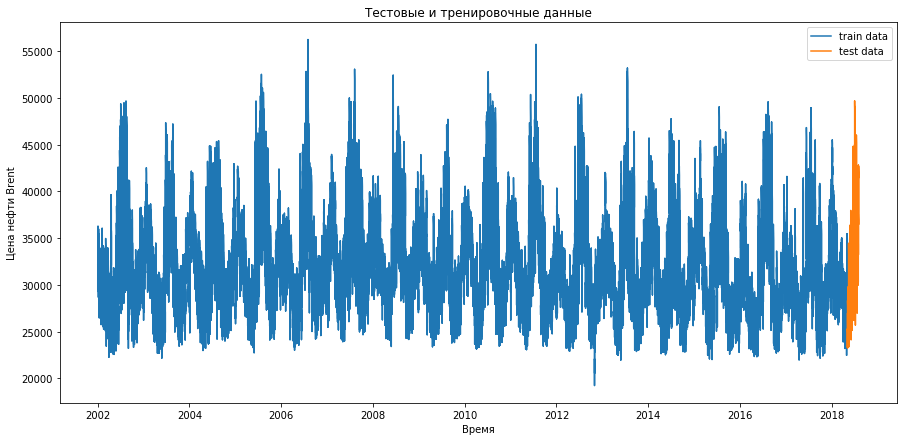

In [9]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
scl =StandardScaler()
scly =StandardScaler()

# сделаем примеры и модель 
def split_data_b( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

train_b, test_b = split_data_b( df, '2018-05-05')

X_train_b = train_b.iloc[:-1,:]
y_train_b = train_b[df.columns[0]].values[1:]
X_test_b = test_b.iloc[:-1,:]
y_test_b = test_b[df.columns[0]].values[1:]


plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Цена нефти Brent')
plt.plot(train_b.index.get_level_values('Date'),train_b[df.columns[0]], label='train data' )
plt.plot(test_b.index.get_level_values('Date'),test_b[df.columns[0]], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

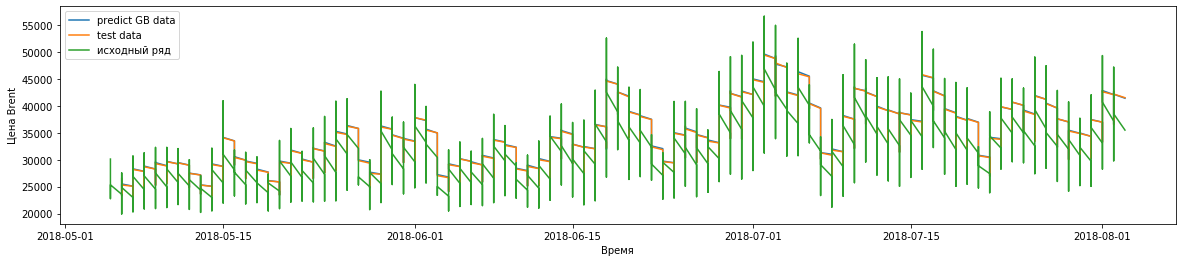

ошибка градиентного бустинга :   0.1633836379614811 %


In [10]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('Потребление энергии')
plt.plot(test_b.index[1:],X_test_pred_gb, label='predict GB data' )
plt.plot(test_b.index[1:],y_test_b, label='test data')
plt.plot(b_s.loc['2018-05-05':].index, b_s.loc['2018-05-05':]['PJME_MW'], label='исходный ряд')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')

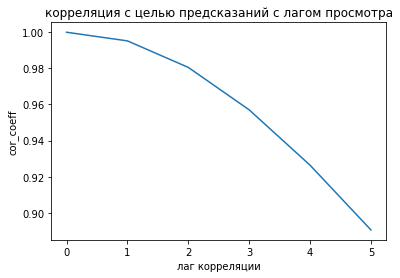

In [11]:
lag=5
p_cor=[np.corrcoef( y_test_b, X_test_pred_gb)[1,0]]
for i in range(lag):
    c=np.corrcoef( y_test_b[:-(i+1)], X_test_pred_gb[(i+1):])[1,0]
    p_cor.append(c)    

plt.plot(np.array(p_cor) ) 
plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')
plt.title('корреляция с целью предсказаний с лагом просмотра')
plt.show()

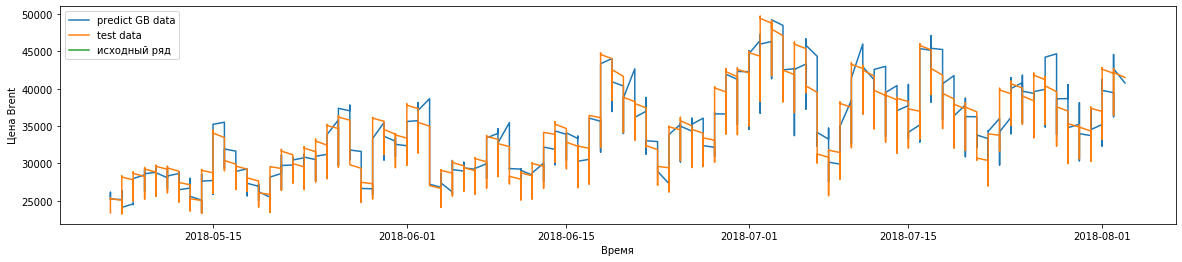

ошибка градиентного бустинга :   5.136682346430337 %


In [12]:
h=10
X_train_b = train_b.iloc[:-h,:]
y_train_b = train_b[df.columns[0]].values[h:]
X_test_b = test_b.iloc[:-h,:]
y_test_b = test_b[df.columns[0]].values[h:]

model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('Потребление энергии')
plt.plot(test_b.index[h:],X_test_pred_gb, label='predict GB data' )
plt.plot(test_b.index[h:],y_test_b, label='test data')
plt.plot(b_s.loc['2018-11-02':].index, b_s.loc['2018-11-02':]['PJME_MW'], label='исходный ряд')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')


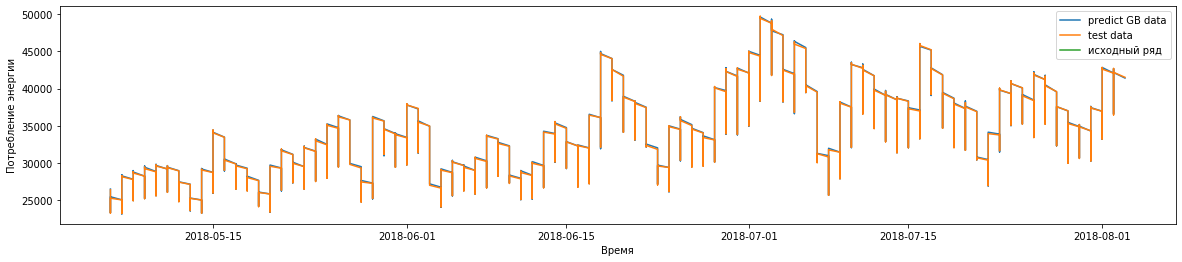

ошибка градиентного бустинга :   0.1633836379614811 %


In [15]:
h=1
X_train_b = train_b.iloc[:-h,:]
y_train_b = train_b[df.columns[0]].values[h:]
X_test_b = test_b.iloc[:-h,:]
y_test_b = test_b[df.columns[0]].values[h:]

model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('Потребление энергии')
plt.plot(test_b.index[h:],X_test_pred_gb, label='predict GB data' )
plt.plot(test_b.index[h:],y_test_b, label='test data')
plt.plot(b_s.loc['2018-11-02':].index, b_s.loc['2018-11-02':]['PJME_MW'], label='исходный ряд')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')


### Ошибка при h = 1 меньше, чем при h=10.

In [24]:
a = np.arange(5)
a

array([0, 1, 2, 3, 4])

In [26]:
for h in a+1:
    X_train_b = train_b.iloc[:-h,:]
    y_train_b = train_b[df.columns[0]].values[h:]
    X_test_b = test_b.iloc[:-h,:]
    y_test_b = test_b[df.columns[0]].values[h:]

    model_gb.fit( X_train_b, y_train_b ) 
    X_test_pred_gb = model_gb.predict(X_test_b)
    er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)
    print(f'ошибка градиентного бустинга : {er_g} % при h = {h}')

ошибка градиентного бустинга : 0.1633836379614811 % при h = 1
ошибка градиентного бустинга : 0.4363157495398233 % при h = 2
ошибка градиентного бустинга : 0.8329209452193672 % при h = 3
ошибка градиентного бустинга : 1.3418876037485994 % при h = 4
ошибка градиентного бустинга : 1.9676162219976903 % при h = 5


# Как видим из цикла, ошибка градиентного спуска пропорционально увеличивается в зависимости от горизонта. 

In [ ]:
4. Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) 
для рядов из списка и аргументируйте свой ответ (одна строка):

а) Изменение температуры за окном :).

б) Количество денег, которые тратят покупатели в интернет магазине.

в) Вес растущего котенка.

г) Прирост объема деревьев в лесу от времени



a) Если взять выборку за большой период, то стационарно, не трендово, сезоно, циклично. Если выборка будет состоять из нескольких лет,
    то гипотетически может быть не стационарно (суровая зима и/или лето, мягкая зима и/или лето), трендово, циклично, сезонно (температура, скорее всего меняется на относительно
    одни и те же цифры)
б) Не стационарно (может быть как рост так и падение), может быть тренд при развитии, есть сезонность, есть элемент цикличности (сезонность в зависимости
от праздников, акций, скидок, необходимости обновлять товары (например, одежду) в зависимости от сезона и так далее).
в) Первый год не стационарно, трендово вверх, с сезоном не связано, не циклично. После года стационарно, не трендово, не сезонно,
    не циклично.
г) В естественных условиях по началу: Не стационарно, возрастающий тренд, циклично (вероятнее всего рост леса увеличивается
    весной и летом и минимален зимой). При достижении определнного уровня включается
    естественный отбор, что ограничивает рост леса и прирост становится не цикличным , не трендовым, не сезонным.  